In [1]:
import os
import kagglehub

# Set download directory to current directory
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir, "leapgestrecog")

# Download dataset to current directory
os.environ['KAGGLEHUB_CACHE'] = current_dir
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Path to dataset files:", path)
print("Current working directory:", current_dir)

c:\Users\ahada\Documents\abdulahad\SkillCraft\hand_gesture_recognition\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Resuming download from 1271922688 bytes (1014162350 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/gti-upm/leapgestrecog?dataset_version_number=1 (1271922688/2286085038) bytes left.
Resuming download from https://www.kaggle.com/api/v1/datasets/download/gti-upm/leapgestrecog?dataset_version_number=1 (1271922688/2286085038) bytes left.


100%|██████████| 2.13G/2.13G [08:05<00:00, 2.09MB/s]

Extracting files...


Path to dataset files: c:\Users\ahada\Documents\abdulahad\SkillCraft\hand_gesture_recognition\datasets\gti-upm\leapgestrecog\versions\1
Current working directory: c:\Users\ahada\Documents\abdulahad\SkillCraft\hand_gesture_recognition


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [ ]:
class HandPoseExtractor:
    def __init__(self, static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5):
        self.hands = mp_hands.Hands(
            static_image_mode=static_image_mode,
            max_num_hands=max_num_hands,
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=0.5
        )

    def extract_landmarks(self, image):
        """Extract hand landmarks from image"""
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image_rgb)

        landmarks = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Extract all 21 landmarks (x, y, z coordinates)
                for landmark in hand_landmarks.landmark:
                    landmarks.extend([landmark.x, landmark.y, landmark.z])

        return np.array(landmarks) if landmarks else np.zeros(63)  # 21 landmarks * 3 coordinates

    def draw_landmarks(self, image, landmarks):
        """Draw hand landmarks on image"""
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style()
                )
        return image

    def close(self):
        self.hands.close()

def organize_dataset(base_path):
    """Organize the dataset structure and create mapping"""
    data = []
    gesture_mapping = {}

    # List all subject folders (00 to 09)
    subject_folders = sorted([f for f in os.listdir(base_path) if f.isdigit()])

    for subject in subject_folders:
        subject_path = os.path.join(base_path, subject)
        gesture_folders = sorted([f for f in os.listdir(subject_path) if os.path.isdir(os.path.join(subject_path, f))])

        for gesture in gesture_folders:
            gesture_path = os.path.join(subject_path, gesture)

            # Create gesture mapping
            if gesture not in gesture_mapping:
                gesture_mapping[gesture] = len(gesture_mapping)

            # Get all image files
            image_files = sorted([f for f in os.listdir(gesture_path) if f.endswith('.png')])

            # Group by video (assuming 100 frames per video)
            for i in range(0, len(image_files), 100):
                video_frames = image_files[i:i+100]
                if len(video_frames) == 100:  # Only use complete sequences
                    for frame_file in video_frames:
                        frame_path = os.path.join(gesture_path, frame_file)
                        data.append({
                            'subject': subject,
                            'gesture': gesture,
                            'gesture_id': gesture_mapping[gesture],
                            'video_id': f"{subject}_{gesture}_{i//100}",
                            'frame_path': frame_path,
                            'frame_number': int(frame_file.split('_')[-1].split('.')[0])
                        })

    return pd.DataFrame(data), gesture_mapping

# Organize the dataset - use the local directory
print("Organizing dataset...")
current_dir = os.getcwd()

from dotenv import load_dotenv
load_dotenv()
base_path = os.getenv("PATH")

# Check if dataset exists
if not os.path.exists(base_path):
    print(f"Error: Dataset not found at {base_path}")
    print("Please run the first cell to download the dataset.")
else:
    df, gesture_mapping = organize_dataset(base_path)
    
    print(f"Total frames: {len(df)}")
    print(f"Number of unique gestures: {len(gesture_mapping)}")
    print(f"Gesture mapping: {gesture_mapping}")

Organizing dataset...
Total frames: 20000
Number of unique gestures: 10
Gesture mapping: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


In [4]:
def extract_dataset_landmarks(df, sample_fraction=1.0):
    """Extract hand landmarks for the entire dataset"""
    extractor = HandPoseExtractor()

    if sample_fraction < 1.0:
        df = df.groupby(['video_id', 'gesture_id']).apply(
            lambda x: x.sample(frac=sample_fraction)
        ).reset_index(drop=True)

    landmarks_data = []
    video_sequences = {}

    print("Extracting hand landmarks...")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image = cv2.imread(row['frame_path'])
            if image is not None:
                landmarks = extractor.extract_landmarks(image)

                video_id = row['video_id']
                if video_id not in video_sequences:
                    video_sequences[video_id] = {
                        'landmarks': [],
                        'gesture_id': row['gesture_id'],
                        'gesture': row['gesture']
                    }

                video_sequences[video_id]['landmarks'].append(landmarks)

        except Exception as e:
            print(f"Error processing {row['frame_path']}: {e}")
            continue

    extractor.close()
    return video_sequences

# Extract landmarks
print("Extracting hand landmarks from dataset...")
video_sequences = extract_dataset_landmarks(df, sample_fraction=1.0)

print(f"Processed {len(video_sequences)} video sequences")

Extracting hand landmarks from dataset...
Extracting hand landmarks...


100%|██████████| 20000/20000 [18:19<00:00, 18.19it/s]


Processed 200 video sequences


In [5]:
def create_sequences(video_sequences, sequence_length=30):
    """Create fixed-length sequences for LSTM training"""
    sequences = []
    labels = []
    gesture_names = []

    for video_id, data in video_sequences.items():
        landmarks_sequence = data['landmarks']
        gesture_id = data['gesture_id']
        gesture_name = data['gesture']

        # Split long sequences into multiple fixed-length sequences
        for i in range(0, len(landmarks_sequence) - sequence_length + 1, sequence_length // 2):
            sequence = landmarks_sequence[i:i + sequence_length]

            # Pad sequence if needed
            if len(sequence) < sequence_length:
                padding = sequence_length - len(sequence)
                sequence = np.pad(sequence, [(0, padding), (0, 0)], mode='constant')

            sequences.append(sequence)
            labels.append(gesture_id)
            gesture_names.append(gesture_name)

    return np.array(sequences), np.array(labels), np.array(gesture_names)

# Create sequences
print("Creating sequences for LSTM...")
sequence_length = 30  # 30-frame sequences
X, y, gesture_names = create_sequences(video_sequences, sequence_length)

print(f"Sequences shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution:")
for gesture_id, count in zip(unique, counts):
    gesture_name = [k for k, v in gesture_mapping.items() if v == gesture_id][0]
    print(f"  {gesture_name}: {count}")

Creating sequences for LSTM...
Sequences shape: (1000, 30, 63)
Labels shape: (1000,)
Class distribution:
  01_palm: 100
  02_l: 100
  03_fist: 100
  04_fist_moved: 100
  05_thumb: 100
  06_index: 100
  07_ok: 100
  08_palm_moved: 100
  09_c: 100
  10_down: 100


In [6]:
class HandPoseAugmentor:
    """Data augmentation for hand pose sequences"""

    @staticmethod
    def add_random_noise(sequence, noise_factor=0.02):
        """Add random noise to landmarks"""
        noise = np.random.normal(0, noise_factor, sequence.shape)
        return sequence + noise

    @staticmethod
    def random_occlusion(sequence, occlusion_prob=0.1):
        """Randomly occlude some landmarks"""
        augmented = sequence.copy()
        for i in range(len(sequence)):
            if np.random.random() < occlusion_prob:
                # Randomly set some landmarks to zero
                mask = np.random.choice([0, 1], size=(63,), p=[0.3, 0.7])
                augmented[i] = augmented[i] * mask
        return augmented

    @staticmethod
    def random_scaling(sequence, scale_range=(0.8, 1.2)):
        """Randomly scale the hand pose"""
        scale = np.random.uniform(scale_range[0], scale_range[1])
        return sequence * scale

    @staticmethod
    def random_translation(sequence, translation_range=(-0.1, 0.1)):
        """Randomly translate the hand pose"""
        translation = np.random.uniform(translation_range[0], translation_range[1], 3)
        augmented = sequence.copy()
        for i in range(len(sequence)):
            # Add translation to x, y, z coordinates
            for j in range(0, 63, 3):
                augmented[i, j:j+3] += translation
        return augmented

def augment_dataset(X, y, augment_factor=2):
    """Augment the dataset with various transformations"""
    augmentor = HandPoseAugmentor()
    X_augmented = []
    y_augmented = []

    print("Augmenting dataset...")
    for i in tqdm(range(len(X))):
        # Original sequence
        X_augmented.append(X[i])
        y_augmented.append(y[i])

        # Augmented sequences
        for _ in range(augment_factor):
            sequence = X[i].copy()

            # Apply random augmentations
            if np.random.random() < 0.7:
                sequence = augmentor.add_random_noise(sequence)
            if np.random.random() < 0.5:
                sequence = augmentor.random_occlusion(sequence)
            if np.random.random() < 0.5:
                sequence = augmentor.random_scaling(sequence)
            if np.random.random() < 0.5:
                sequence = augmentor.random_translation(sequence)

            X_augmented.append(sequence)
            y_augmented.append(y[i])

    return np.array(X_augmented), np.array(y_augmented)

# Augment the dataset
X_augmented, y_augmented = augment_dataset(X, y, augment_factor=2)

print(f"Original dataset size: {len(X)}")
print(f"Augmented dataset size: {len(X_augmented)}")

Augmenting dataset...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 945.27it/s]

Original dataset size: 1000
Augmented dataset size: 3000


In [7]:
def create_lstm_model(input_shape, num_classes, lstm_units=128, dropout_rate=0.3):
    """Create LSTM model for hand gesture recognition"""
    model = Sequential([
        # First LSTM layer (GPU compatible)
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Second LSTM layer
        LSTM(lstm_units, return_sequences=True),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Third LSTM layer
        LSTM(lstm_units // 2, return_sequences=False),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Dense layers (these can keep kernel_initializer)
        Dense(256, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(128, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    return model


# Prepare data for training
X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Create and compile model
num_classes = len(gesture_mapping)
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)

model = create_lstm_model(input_shape, num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Training set: (1920, 30, 63)
Validation set: (480, 30, 63)
Test set: (600, 30, 63)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,938 (1.27 MB)

 Trainable params: 331,530 (1.26 MB)

 Non-trainable params: 1,408 (5.50 KB)

None


Training LSTM model...
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.1802 - loss: 2.6696 - val_accuracy: 0.2125 - val_loss: 2.0914 - learning_rate: 0.0010
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.2406 - loss: 2.3100 - val_accuracy: 0.1875 - val_loss: 2.1013 - learning_rate: 0.0010
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.2833 - loss: 2.0608 - val_accuracy: 0.2958 - val_loss: 1.7402 - learning_rate: 0.0010
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.2964 - loss: 1.9487 - val_accuracy: 0.3958 - val_loss: 1.6226 - learning_rate: 0.0010
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.3240 - loss: 1.8694 - val_accuracy: 0.2625 - val_loss: 1.8193 - learning_rate: 0.0010
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.3260 - loss: 1.7640 - val_accuracy: 0.3646 - val_loss: 1.7815 - learning_rate: 0.0010
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 

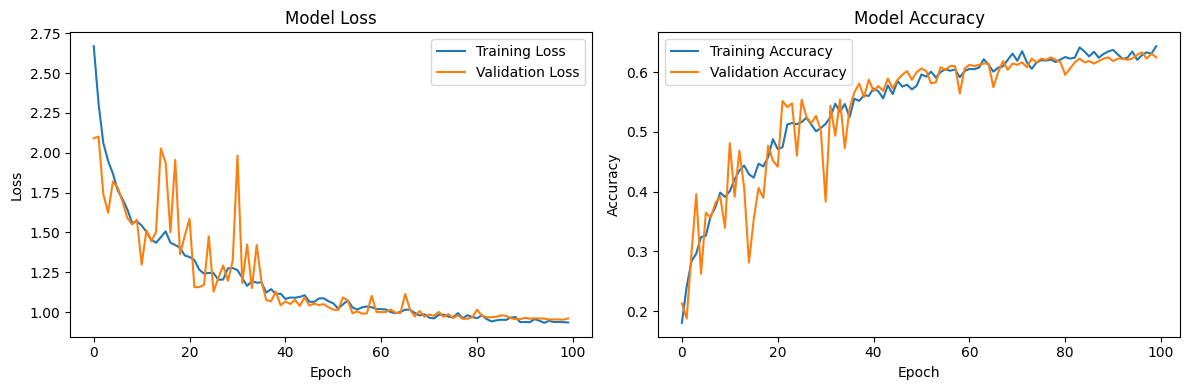

In [8]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
]

# Train the model
print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.6217
Test Loss: 0.9686
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00        60
         02_l       0.97      0.65      0.78        60
      03_fist       0.92      0.37      0.52        60
04_fist_moved       0.23      0.93      0.37        60
     05_thumb       1.00      0.55      0.71        60
     06_index       1.00      0.42      0.59        60
        07_ok       1.00      1.00      1.00        60
08_palm_moved       0.42      0.35      0.38        60
         09_c       0.68      0.28      0.40        60
      10_down       0.98      0.67      0.79        60

     accuracy                           0.62       600
    macro avg       0.82      0.62      0.65       600
 weighted avg       0.82      0.62      0.65       600


Classification Report:
               precision    recall  f1-score   support

   

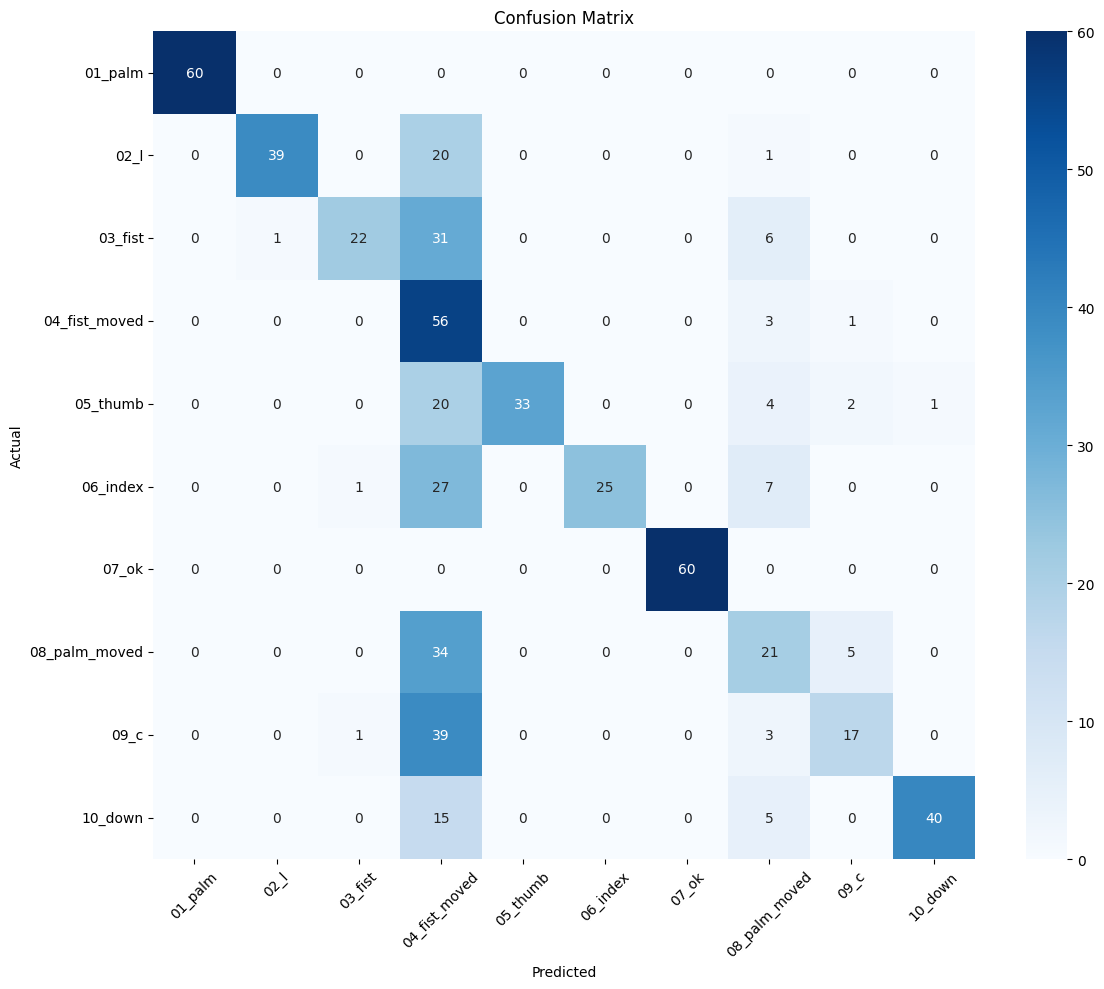

Model saved as 'hand_gesture_lstm_model.h5'
Gesture mapping saved as 'gesture_mapping.json'


In [13]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
class_names = list(gesture_mapping.keys())
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save the model
model.save('hand_gesture_lstm_model.h5')
print("Model saved as 'hand_gesture_lstm_model.h5'")

# Save gesture mapping for webcam testing
import json
with open('gesture_mapping.json', 'w') as f:
    json.dump(gesture_mapping, f, indent=2)
print("Gesture mapping saved as 'gesture_mapping.json'")

In [10]:
class RealTimeGestureRecognizer:
    def __init__(self, model_path, gesture_mapping, sequence_length=30):
        self.model = tf.keras.models.load_model(model_path)
        self.gesture_mapping = gesture_mapping
        self.sequence_length = sequence_length
        self.sequence = []
        self.extractor = HandPoseExtractor(static_image_mode=False)

        # Reverse gesture mapping
        self.id_to_gesture = {v: k for k, v in gesture_mapping.items()}

    def process_frame(self, frame):
        """Process a single frame and return gesture prediction"""
        # Extract landmarks
        landmarks = self.extractor.extract_landmarks(frame)

        # Add to sequence
        self.sequence.append(landmarks)

        # Maintain fixed sequence length
        if len(self.sequence) > self.sequence_length:
            self.sequence = self.sequence[-self.sequence_length:]

        # Predict if we have enough frames
        if len(self.sequence) == self.sequence_length:
            sequence_array = np.array([self.sequence])
            predictions = self.model.predict(sequence_array, verbose=0)
            predicted_class = np.argmax(predictions[0])
            confidence = np.max(predictions[0])

            gesture_name = self.id_to_gesture[predicted_class]
            return gesture_name, confidence

        return "Collecting frames...", 0.0

    def draw_prediction(self, frame, gesture, confidence):
        """Draw prediction on frame"""
        # Draw landmarks
        frame_with_landmarks = self.extractor.draw_landmarks(frame.copy(), None)

        # Add prediction text
        text = f"{gesture} ({confidence:.2f})"
        cv2.putText(frame_with_landmarks, text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        return frame_with_landmarks

    def run_webcam_demo(self):
        """Run real-time webcam demo"""
        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Error: Could not open webcam")
            return

        print("Starting real-time gesture recognition. Press 'q' to quit.")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Flip frame horizontally for mirror effect
            frame = cv2.flip(frame, 1)

            # Process frame
            gesture, confidence = self.process_frame(frame)

            # Draw prediction
            output_frame = self.draw_prediction(frame, gesture, confidence)

            # Display frame
            cv2.imshow('Hand Gesture Recognition', output_frame)

            # Break on 'q' key
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.extractor.close()

# Test real-time recognition
# recognizer = RealTimeGestureRecognizer('hand_gesture_lstm_model.h5', gesture_mapping)
# recognizer.run_webcam_demo()

In [ ]:
import shutil

# Cleanup: Delete the downloaded dataset to save space
def cleanup_dataset():
    """Delete the downloaded dataset after training"""
    current_dir = os.getcwd()
    dataset_dir = os.path.join(current_dir, "leapgestrecog")
    
    if os.path.exists(dataset_dir):
        print(f"Deleting dataset directory: {dataset_dir}")
        shutil.rmtree(dataset_dir)
        print("Dataset deleted successfully!")
    else:
        print(f"Dataset directory not found: {dataset_dir}")
    
    # Also check for kagglehub cache
    kagglehub_cache = os.path.join(current_dir, ".cache")
    if os.path.exists(kagglehub_cache):
        print(f"Deleting kagglehub cache: {kagglehub_cache}")
        shutil.rmtree(kagglehub_cache)
        print("Cache deleted successfully!")

# Call cleanup function
print("\n" + "="*60)
print("CLEANUP: Removing downloaded dataset files")
print("="*60)
cleanup_dataset()
print("\nTraining complete! Dataset has been removed to save space.")